In [1]:
!git clone https://github.com/beckhamtoh/char-llm-assignment.git
%cd char-llm-assignment

Cloning into 'char-llm-assignment'...
remote: Enumerating objects: 151, done.
remote: Counting objects: 100% (151/151), done.
remote: Compressing objects: 100% (102/102), done.
remote: Total 151 (delta 70), reused 110 (delta 36), pack-reused 0 (from 0)
Receiving objects: 100% (151/151), 31.87 MiB | 21.27 MiB/s, done.
Resolving deltas: 100% (70/70), done.
/kaggle/working/char-llm-assignment


In [2]:
# Enable autoreload of local Python modules (e.g., models)
# %load_ext autoreload
# %autoreload 2

# manual reload for local modules
import importlib

In [3]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import numpy as np
import jax
import jax.numpy as jnp
import optax
import time

# local imports
import models.models as models
import util.generation as generation


In [4]:
# initialize the jax random key
key = jax.random.key(0)

INFO:2025-11-01 16:11:06,829:jax._src.xla_bridge:924: Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO:2025-11-01 16:11:06,839:jax._src.xla_bridge:924: Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory


# Load data

In [5]:
# load the ./data/text8_train.txt and ./data/text8_test.txt files
with open("./data/text8_train.txt", "r") as f:
    train_text = f.read()
with open("./data/text8_test.txt", "r") as f:
    test_text = f.read()

# print the length of the training text and test text
print(f"Length of training text: {len(train_text):_} characters")
print(f"Length of test text: {len(test_text):_} characters")

Length of training text: 90_000_000 characters
Length of test text: 5_000_000 characters


In [6]:
# Build vocabulary (lowercase + space + a few punctuations)
char_set = list("abcdefghijklmnopqrstuvwxyz ")
char_to_int = {ch:i for i,ch in enumerate(char_set)}
int_to_char = {i:ch for ch,i in char_to_int.items()}

def encode(s):
    """Encode string to array of integers"""
    ids = [char_to_int[c] for c in s]
    return np.array(ids, dtype=np.uint8)  # use np.uint8 to save space

In [7]:
# encode the text
train_text_int = encode(train_text)
test_text_int = encode(test_text)

In [8]:
# sanity check: display a few random characters from the training text
T = 128
for _ in range(5):
    # choose random position in text
    N = np.random.randint(low=0, high=len(train_text)-T)
    print(train_text[N:N+T])
    print()

or olio that wad staw a sow or fricassee wad mak her spew wi perfect scunner looks down wi sneering scornfu view on sic a dinner

e era he wished to go in the end the very place nobita wanted to go is heaven however the plausibility of the issues was discuss

wo zero zero four world english bibliography from a bibliography of literary theory criticism and philology one zero th ed unive

nown as iodized salt iodine deficiency is the leading cause of preventable mental retardation iodine deficency remains a serious

eight three to early one nine eight four adventure international employed approximately five zero individuals and published titl



# Create a basic Transformer model

In [9]:
def create_train_state(rng, vocab_size=27, d_model=64, n_layers=6, n_heads=8, max_len=128):
    # create a basic Transformer model
    model = models.DecoderOnlyTransformer(vocab_size, d_model, n_layers, n_heads, max_len)
    # create a dummy input for initialization
    dummy = jnp.zeros((1, min(16, max_len)), dtype=jnp.int32)
    # pass the dummy input to the model to initialize the parameters
    params = model.init({"params": rng}, dummy)["params"]
    return model, params

In [10]:
# vocab size
vocab_size= len(char_set)

# internal model dimensions
d_model=256

# number of attention heads
n_heads=4

# number of Transformer layers
n_layers=4

# maximum sequence length
max_len=128

model, params = create_train_state(key, vocab_size, d_model, n_layers, n_heads, max_len)

In [11]:
# compute the number of parameters
def count_params(params):
    return sum(x.size for x in jax.tree_util.tree_leaves(params))
print(f"Number of parameters: {count_params(params):_}")

Number of parameters: 3_202_048


In [12]:
# sanity check: create a batch of data & run a forward pass
B, T = 4, 32
batch = jax.random.randint(
    key=key,
    shape=(B, T), minval=0, maxval=len(char_set))
logits = model.apply({"params": params}, batch)

print("batch shape:", batch.shape)  # (B, T)
print("logits shape:", logits.shape)  # (B, T, vocab_size)

batch shape: (4, 32)
logits shape: (4, 32, 27)


# Loss function

In [13]:
@jax.jit
def loss_and_metrics(logits, targets, last_token_only = False):
    """Compute cross-entropy loss and accuracy.

    Args:
      logits: (B, T, V) float array of unnormalized scores.
      targets: (B, T) integer array with ground-truth class ids.
      last_token_only: If True, compute loss only on the last token position.

    Returns:
      loss: scalar average cross-entropy.
      metrics: dict with keys "loss", "acc", and "acc_last".
    """
    vocab = logits.shape[-1]
    flat_logits = logits.reshape(-1, vocab)
    flat_targets = targets.reshape(-1)

    # Compute per-position cross-entropy
    per_pos = optax.softmax_cross_entropy_with_integer_labels(flat_logits, flat_targets)
    
    if last_token_only:
        # Reshape back to (B, T) and take only last token
        per_pos = per_pos.reshape(targets.shape)  # (B, T)
        loss = per_pos[:, -1].mean()  # Average over batch, last position only
    else:
        # Original behavior: average over all positions
        loss = per_pos.mean()

    # Predictions and accuracy (unchanged)
    preds = jnp.argmax(logits, axis=-1)
    is_match = preds == targets
    acc_all = jnp.mean(is_match.astype(jnp.float32))
    acc_last = jnp.mean(is_match[:, -1].astype(jnp.float32))

    return loss, {"loss": loss, "acc": acc_all, "acc_last": acc_last}

# Optimization step:

In [14]:
# create an update function
def train_step(params, opt_state, x, y, tx):
    """Single optimization step using optax optimizer.

    Args:
      params: pytree of model parameters.
      opt_state: optax optimizer state corresponding to `params`.
      x: (B, T) int array input tokens.
      y: (B, T) int array target tokens.
      tx: optax.GradientTransformation (already initialized).

    Returns:
      new_params: updated parameters after one gradient step.
      new_opt_state: updated optimizer state.
      metrics: dict of scalar metrics (loss, acc).
    """
    def loss_fn(params):
        logits = model.apply({"params": params}, x)
        loss, metrics = loss_and_metrics(logits, y)
        return loss, metrics

    # compute gradients (loss is scalar, metrics is auxiliary)
    (loss, metrics), grads = jax.value_and_grad(loss_fn, has_aux=True)(params)

    # optax update: compute parameter updates and new optimizer state
    updates, new_opt_state = tx.update(grads, opt_state, params)
    new_params = optax.apply_updates(params, updates)
    return new_params, new_opt_state, metrics

# jit: last argument should be static because it is an object
train_step = jax.jit(train_step, static_argnames=("tx",))

# Batch creation:

In [15]:
# create a batch from the training data
def get_batch(text_int, B, T):
    """Create a random batch of data from text_int.

    Args:
      text_int: 1D array of token ids.
      B: batch size (number of sequences).
      T: sequence length (number of tokens per sequence).

    Returns:
      x: (B, T) int array input tokens.
      y: (B, T) int array target tokens.
    """
    # choose random starting indices for each sequence in the batch
    ix = np.random.randint(0, len(text_int) - T, size=B)
    # inputs are text from i to i+T
    x = np.stack([text_int[i:i+T] for i in ix])
    # targets are text from i+1 to i+T+1
    y = np.stack([text_int[i+1:i+T+1] for i in ix])
    return jnp.array(x, dtype=jnp.int32), jnp.array(y, dtype=jnp.int32)

# Optimizer creation:

In [16]:
# ---- CONFIG ----
niter = 100_000
B, T = 256, 32           # changed batch size 128 --> 256
B_test, T_test = 1024, 32

base_lr = 1e-4           # pick your base LR here
warmup_frac = 0.1
weight_decay = 1e-4

# ---- COSINE WARMUP + DECAY SCHEDULE ----
warmup_steps = int(warmup_frac * niter)
decay_steps  = niter - warmup_steps

def make_full_cosine(base_lr):
    def schedule(step):
        s = jnp.minimum(step, 1_000_000)
        warmup_lr = base_lr * (s / warmup_steps)
        cosine_decay = 0.5 * (1 + jnp.cos(jnp.pi * (s - warmup_steps) / decay_steps))
        cosine_lr = base_lr * cosine_decay
        return jnp.where(s < warmup_steps, warmup_lr, cosine_lr)
    return schedule

schedule_fn = make_full_cosine(base_lr)

# ---- OPTIMIZER ----
tx = optax.chain(
    optax.clip_by_global_norm(1.0),
    optax.adamw(learning_rate=schedule_fn, weight_decay=weight_decay)
)
opt_state = tx.init(params)

# ---- TRAINING LOOP ----
loss_history = []
time_history = []
time_test_history = []
loss_test_history = []

time_start = time.time()

for it in range(niter):
    # --- training step ---
    input, target = get_batch(train_text_int, B, T)
    params, opt_state, metrics = train_step(params, opt_state, input, target, tx)

    loss = float(metrics['loss'])
    acc = float(metrics['acc'])
    acc_last = float(metrics['acc_last'])

    loss_history.append(loss)
    time_history.append(time.time() - time_start)

    # --- optionally record current LR ---
    current_lr = float(schedule_fn(it))

    # --- periodic test ---
    if it % (niter // 50) == 0 or it == niter - 1:
        time_since_start = time.time() - time_start

        test_input, test_target = get_batch(test_text_int, B_test, T_test)
        test_logits = model.apply({"params": params}, test_input)
        test_loss, test_metrics = loss_and_metrics(test_logits, test_target)

        test_acc = float(test_metrics['acc'])
        test_acc_last = float(test_metrics['acc_last'])
        loss_test_history.append(float(test_loss))
        time_test_history.append(time_since_start)

        print(f"iteration {it:_}  time: {time_since_start:.1f} seconds")
        print(f"\t \t loss(train :: test): {loss:.4f} :: {test_loss:.4f}")
        print(f"\t \t accuracy (train :: test): {100*acc:.1f}% :: {100*test_acc:.1f}%")
        print(f"\t \t accuracy (last character) (train :: test): {100*acc_last:.1f}% :: {100*test_acc_last:.1f}%")
        print(f"\t \t learning rate: {current_lr:.6f}")
        print()


iteration 0  time: 7.1 seconds
	 	 loss(train :: test): 3.9245 :: 3.9188
	 	 accuracy (train :: test): 3.0% :: 2.9%
	 	 accuracy (last character) (train :: test): 2.0% :: 2.2%
	 	 learning rate: 0.000000

iteration 2_000  time: 141.5 seconds
	 	 loss(train :: test): 1.9979 :: 2.0312
	 	 accuracy (train :: test): 39.2% :: 38.4%
	 	 accuracy (last character) (train :: test): 36.7% :: 36.4%
	 	 learning rate: 0.000020

iteration 4_000  time: 275.4 seconds
	 	 loss(train :: test): 1.7218 :: 1.6931
	 	 accuracy (train :: test): 47.4% :: 48.4%
	 	 accuracy (last character) (train :: test): 49.6% :: 51.8%
	 	 learning rate: 0.000040

iteration 6_000  time: 410.0 seconds
	 	 loss(train :: test): 1.5616 :: 1.5402
	 	 accuracy (train :: test): 51.9% :: 52.3%
	 	 accuracy (last character) (train :: test): 53.5% :: 54.4%
	 	 learning rate: 0.000060

iteration 8_000  time: 544.3 seconds
	 	 loss(train :: test): 1.4894 :: 1.5045
	 	 accuracy (train :: test): 54.3% :: 53.6%
	 	 accuracy (last charact

In [17]:
# # define optax optimizer
# learning_rate = 0.001
# # Create Adam optimizer (Optax)
# tx = optax.adam(learning_rate=learning_rate)
# # Initialize optimizer state for current params
# opt_state = tx.init(params)
# print(f"Initialized optimizer: Adam lr={learning_rate}")



In [18]:
# niter = 100_000
# B, T = 128, 32

# # cosine warmup schedule (full schedule)
# warmup_steps = int(0.1 * niter)
# decay_steps  = niter - warmup_steps

# def make_full_cosine(base_lr):
#     def schedule(step):
#         s = jnp.minimum(step, 1_000_000)
#         warmup_lr = base_lr * (s / warmup_steps)
#         cosine_decay = 0.5 * (1 + jnp.cos(jnp.pi * (s - warmup_steps) / decay_steps))
#         cosine_lr = base_lr * cosine_decay
#         return jnp.where(s < warmup_steps, warmup_lr, cosine_lr)
#     return schedule

# loss_history = []
# time_history = []
# time_test_history = []
# loss_test_history = []
# time_start = time.time()

# for it in range(niter):
#     batch = get_batch(train_text_int, B, T)
#     input, target = batch[0], batch[1]
#     params_new, opt_state_new, metrics = train_step(params, opt_state, input, target, tx)

#     # update params and opt_state
#     params = params_new
#     opt_state = opt_state_new
#     acc = metrics['acc']
#     acc_last = metrics['acc_last']
#     loss = metrics['loss']

#     loss_history.append(loss)
#     time_history.append(time.time() - time_start)

#     if it % (niter // 50) == 0 or it == niter - 1:
#         time_since_start = time.time() - time_start
#         # compute loss on test set
#         B_test, T_test = 1024, 32
#         test_batch = get_batch(test_text_int, B_test, T_test)
#         test_input, test_target = test_batch[0], test_batch[1]
#         test_logits = model.apply({"params": params}, test_input)
#         test_loss, test_metrics = loss_and_metrics(test_logits, test_target)
#         test_acc = test_metrics['acc']
#         test_acc_last = test_metrics['acc_last']
#         loss_test_history.append(test_loss)
#         time_test_history.append(time_since_start)
#         print(f"iteration {it:_}  time: {time_since_start:.1f} seconds")
#         print(f"\t \t loss(train :: test): {loss:.4f} :: {test_loss:.4f}")
#         print(f"\t \t accuracy (train :: test): {100*acc:.1f}% :: {100*test_acc:.1f}%")
#         print(f"\t \t accuracy (last character) (train :: test): {100*acc_last:.1f}% :: {100*test_acc_last:.1f}%")
#         print()


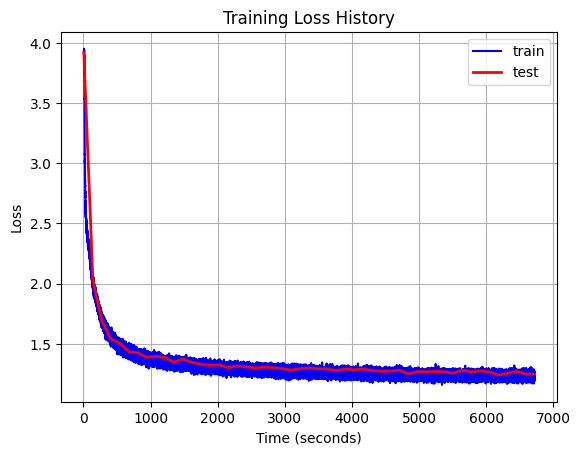

In [19]:
# plot the loss history
import matplotlib.pyplot as plt
plt.plot(time_history, loss_history, '-', label='train', color="blue")
plt.plot(time_test_history, loss_test_history, '-', label='test', lw=2, color="red")
plt.xlabel("Time (seconds)")
plt.ylabel("Loss")
plt.legend(loc='upper right')
plt.title("Training Loss History")
plt.grid()

In [20]:
B = 1
seed = 42
rng = jax.random.PRNGKey(seed)
prompt = "hello my fri"
# prompt_int = encode(prompt.lower())
prompt_int = jnp.array([ [char_to_int.get(c, len(char_set)) for c in prompt.lower()[:64]] ], dtype=jnp.int32)

gen_len = 1000
out_ids = generation.generate_tokens(model, params, rng, prompt_int, gen_len, block_size=64,
                          temperature=0.7, sample=True)
print('generated ids shape:', out_ids.shape)
print('generated text:')
generated_text = ''.join(int_to_char.get(int(x), '?') for x in list(out_ids[0]))
# concatenate with prompt
print(prompt + generated_text)
#print(''.join(int_to_char.get(int(x), '?') for x in list(out_ids[0])))

generated ids shape: (1, 1000)
generated text:
hello my fri il n c n o bs l h sh oi onom clinigapmanndhnd rp esacoccakacintt cou ea a m yothuclmeidal miou e chte msm tws clios ds l amoatantathendimik t b j ararsmaisc tha a an e sy ruan rwntanesibi t fa m salnd thalthfcetois oe ack p te d ppet c oanfioe t t aenmdewcarnd c wsing palockthec t g sdin can g m teoeingoch malisaeoupinth iszam g einnthfeelindet p os isoospe x cs arspira oialsd c avthesima f xid hstrotit t alest es aooto bpa xy phee iainindecalinalanth inganthdala and ipigmbe ty eo ais ta he a o kssocatrett saisainnscanyc el bi t gm p ar overth aanibisieascr sigs t intand arawisstasi yr oeparsalc s ychpartison tenouluanar ateelat sostel r tiscco tasm e tiseli animialo ar ysae ndestear e osthandeibs igric tegnd tal ondintalate a sthrseneaplra m chseckhsoo an alozlanast ta car cdtea ptee sthc wnt ae oouchnt casc an prorrlea tt hysgant omoes mgbded ctiene isalisa sthtalesnthais pins irlrainte temsilel e oe i t ptamalige tioeassrie